In [2]:

import nest_asyncio
nest_asyncio.apply()

import autogen
import json
import pandas as pd
import concurrent.futures
from datetime import datetime
from typing import Union, List, Dict
import os
import numpy as np
import re

# from eval.utils import *

In [3]:
questions = [
"""
Create a comprehensive table comparing representation learning models for polymers. Include the following information for each model:

Model name
Year introduced
Key authors/research group
Type of representation (e.g., graph-based, sequence-based, 3D structure-based)
Input features used
Dimensionality of the learned representation
Training data type and size
Key applications (e.g., property prediction, polymer design)
Notable advantages
Limitations or challenges

After the table, provide a brief analysis (2-3 paragraphs) of the current trends in polymer representation learning, highlighting the most promising approaches and areas for future research. Please cite relevant papers for each model and in your analysis.
""",
"""
Create a comparative analysis of machine learning models used for predicting glass transition temperature (Tg) and melting temperature (Tm) of polymers. Include the following in your analysis:

A table comparing at least 5 different models, with the following information for each:
a) Model name and type (e.g., Random Forest, Neural Network, etc.)
b) Year introduced
c) Key authors/research group
d) Input features or representation used
e) Dataset size and composition
f) Accuracy metrics for Tg prediction (e.g., R², RMSE, MAE)
g) Accuracy metrics for Tm prediction (e.g., R², RMSE, MAE)
h) Computational complexity or training time (if available)
A brief discussion (2-3 paragraphs) on:
a) The overall trends in prediction accuracy for Tg vs Tm
b) Factors that contribute to higher accuracy in certain models
c) Challenges in predicting these properties accurately
d) Recent advancements or novel approaches in the field
A short section on potential areas for improvement and future research directions.

Please provide citations for the models and studies mentioned in your analysis.
"""
]

models = ['gpt-4', 'gpt-4o', 'gpt-4o-mini', 'gpt-35-turbo', 'gpt-35-turbo-16k']

# input_dir = '/home/azureuser/autogen_uscases/graphrag_memo/output/20240830-145930/artifacts'
input_dir = '/home/azureuser/autogen_uscases/autosearch/notebooks/graphrag/output/20240903-050706/artifacts'
# input_dir = '/home/azureuser/autogen_uscases/graphrag_memo/output/20240830-145930/artifacts'
lancedb_uri = "/home/azureuser/autogen_uscases/autosearch/notebooks/graphrag/output/20240903-050706/artifacts/lancedb"
embedding_model = 'text-embedding-3-small'

results_json = 'results_20240903_094137.json'
df_results = pd.read_json(results_json)
df_results.head(1)

,question,model,local_result,global_result
0,\nCreate a comprehensive table comparing repre...,gpt-4,"Unfortunately, I do not have access to externa...",I am sorry but I am unable to answer this ques...


In [4]:
import code


config_list = autogen.config_list_from_json(
    "../OAI_CONFIG_LIST-sweden-505",
    file_location=".",
    filter_dict={
        "model": ["gpt-4"]
    },
)

llm_config = {
    "config_list": config_list,
    "timeout": 120,
}

# Create the GPT-4 agent
gpt4_agent = autogen.AssistantAgent(
    name="gpt4_evaluator",
    llm_config=llm_config
)

# Create a user proxy agent
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config=False,
)


def create_pair_evaluation_prompt(df_results: pd.DataFrame, question: str, model1: str, model2: str, search_method: str = 'global_result') -> str:
    result1 = df_results[(df_results['question'] == question) & (df_results['model'] == model1)][search_method].iloc[0]
    result2 = df_results[(df_results['question'] == question) & (df_results['model'] == model2)][search_method].iloc[0]
    
    prompt = f"""
    Evaluate and compare the following search results for the question: "{question}"
    
    Model 1 ({model1}) search result:
    {result1}
    
    Model 2 ({model2}) search result:
    {result2}
    
    Please provide a detailed evaluation considering the following criteria:
    1. Relevance: How well does each result address the question?
    2. Completeness: Which result provides more comprehensive information?
    3. Accuracy: Are there any apparent errors or inconsistencies in either result?
    4. Clarity: Which result is easier to understand?
    5. Unique insights: Does either result provide unique information not present in the other?
    6. Coherence: How well-structured and logically connected is the information in each result?
    7. Source diversity: Does the result appear to draw from a variety of sources or perspectives?
    
    For each criterion, provide a brief explanation of your reasoning, followed by a score for both Model 1 and Model 2 on a scale of 1-10.
    
    After your analysis, provide an overall score for each result, taking into account all the above criteria.
    
    Finally, conclude with a brief statement on which model's result you think is better for this particular question and why.
    
    At the end of your analysis, provide a structured table with all the numerical scores using the following format:

    EVALUATION TABLE
    | Criterion        | {model1} Score | {model2} Score |
    |------------------|----------------|----------------|
    | Relevance        |                |                |
    | Completeness     |                |                |
    | Accuracy         |                |                |
    | Clarity          |                |                |
    | Unique Insights  |                |                |
    | Coherence        |                |                |
    | Source Diversity |                |                |
    | Overall          |                |                |

    Fill in the table with your numerical scores, ensuring all scores are between 1 and 10.

    End your evaluation with the word TERMINATE.
    """
    return prompt

def evaluate_model_pair(df_results: pd.DataFrame, question: str, model1: str, model2: str, search_method: str = 'global_result') -> Dict:
    prompt = create_pair_evaluation_prompt(df_results, question, model1, model2, search_method)
    
    # Use the existing user_proxy and gpt4_agent for evaluation
    user_proxy.initiate_chat(
        gpt4_agent,
        message=prompt,
    )
    
    evaluation = user_proxy.last_message()["content"]
    scores = parse_evaluation_table(evaluation)
    
    if not scores:
        print(f"Warning: Failed to parse scores for question: {question}, models: {model1} vs {model2}")
        scores = {criterion: {model1: 0, model2: 0} for criterion in 
                  ["relevance", "completeness", "accuracy", "clarity", "unique_insights", "coherence", "source_diversity", "overall"]}
    
    return {
        "question": question,
        "model1": model1,
        "model2": model2,
        "search_method": search_method,
        "evaluation": evaluation,
        "scores": scores
    }

import re
from typing import Dict, List, Union

def find_evaluation_table(evaluation: str) -> Union[str, None]:
    # Try different patterns to locate the table
    patterns = [
        r'(?:\*\*)?EVALUATION TABLE(?:\*\*)?\s*(?:```)?(?:\n)?((?:\|.*\|(?:\n|$))+)(?:```)?',
        r'EVALUATION TABLE\s*(?:```)?(?:\n)?((?:\|.*\|(?:\n|$))+)(?:```)?',
        r'Scores:.*?(?:\n\n|\n)(?:\*\*)?EVALUATION TABLE(?:\*\*)?\s*(?:```)?(?:\n)?((?:\|.*\|(?:\n|$))+)(?:```)?',
    ]
    
    for pattern in patterns:
        match = re.search(pattern, evaluation, re.IGNORECASE | re.DOTALL)
        if match:
            return match.group(1).strip()
    
    return None

def parse_evaluation_table(evaluation: str) -> Dict[str, Dict[str, float]]:
    try:
        table_text = find_evaluation_table(evaluation)
        if not table_text:
            raise ValueError("Evaluation table not found in the text")
        
        lines = [line.strip() for line in table_text.split('\n') if line.strip()]
        
        # Parse header
        header = [col.strip() for col in re.split(r'\s*\|\s*', lines[0]) if col.strip()]
        model_names = [col.replace(' Score', '').strip() for col in header[1:]]
        
        scores = {}
        for line in lines[2:]:  # Skip header and separator rows
            parts = [part.strip() for part in re.split(r'\s*\|\s*', line) if part.strip()]
            if len(parts) >= 3:
                criterion = parts[0].lower().replace(' ', '_')
                try:
                    model_scores = {model: parse_score(score) for model, score in zip(model_names, parts[1:])}
                    scores[criterion] = model_scores
                except ValueError as e:
                    print(f"Warning: {str(e)} for criterion {criterion}")
        
        if not scores:
            raise ValueError("No valid scores found in the evaluation table")
        
        return scores
    except Exception as e:
        print(f"Error parsing evaluation table: {str(e)}")
        return {}

def parse_score(score_str: str) -> float:
    score_str = score_str.strip().lower()
    if score_str in ['n/a', 'na', ''] or not re.search(r'\d', score_str):
        return float('nan')
    try:
        score = float(score_str)
        if 0 <= score <= 10:
            return score
        else:
            raise ValueError(f"Score out of range: {score}")
    except ValueError:
        raise ValueError(f"Invalid score format: {score_str}")


def extract_score(score_dict: Dict[str, float], model_name: str) -> float:
    # Look for an exact match first
    exact_match = f"{model_name} Score"
    if exact_match in score_dict:
        return score_dict[exact_match]
    
    # If no exact match, look for a close match (in case the 'Score' suffix is missing)
    for key, value in score_dict.items():
        if key.lower() == model_name.lower():
            return value
    
    # If still no match, return NaN
    return np.nan

def create_comparison_dataframe(evaluations: List[Dict], questions: List[str], model1: str, model2: str) -> pd.DataFrame:
    # Create a multi-level column index
    columns = pd.MultiIndex.from_product([questions, ['Criterion', model1, model2]])
    
    # Create an empty DataFrame with the multi-level columns
    result_df = pd.DataFrame(columns=columns)
    
    # Fill the DataFrame with data
    criteria = ["relevance", "completeness", "accuracy", "clarity", "unique_insights", "coherence", "source_diversity", "overall"]
    
    for i, criterion in enumerate(criteria):
        row_data = []
        for question in questions:
            # Find the corresponding evaluation data
            eval_data = next((e for e in evaluations if e['question'] == question), None)
            
            if eval_data is not None and 'scores' in eval_data:
                scores = eval_data['scores']
                if criterion in scores:
                    score_dict = scores[criterion]
                    row_data.extend([
                        criterion.capitalize(),
                        extract_score(score_dict, model1),
                        extract_score(score_dict, model2)
                    ])
                else:
                    row_data.extend([criterion.capitalize(), np.nan, np.nan])
            else:
                row_data.extend([criterion.capitalize(), np.nan, np.nan])
        
        result_df.loc[i] = row_data
    
    return result_df




In [5]:
def evaluate_and_create_dataframe(df_results: pd.DataFrame, questions: List[str], model1: str, model2: str, search_method: str = 'global_result'):
    evaluations = []
    scores = []
    for question in questions:
        evaluation = evaluate_model_pair(df_results, question, model1, model2, search_method)
        evaluations.append(evaluation)
        scores.append(evaluation['scores'])
        
    comparison_df = create_comparison_dataframe(evaluations, questions, model1, model2)
    return comparison_df, scores

In [6]:

# Usage remains the same
questions = df_results['question'].unique().tolist()
models = df_results['model'].unique().tolist()
model_pairs = [('gpt-4o', 'gpt-35-turbo'), ('gpt-4o', 'gpt-4'), ('gpt-4o', 'gpt-35-turbo-16k')]
search_methods = ['global_result', 'local_result']

comparison_dfs = {}
scores = {}

for model1, model2 in model_pairs:
    for search_method in search_methods:
        comparison_df, score = evaluate_and_create_dataframe(df_results, questions, model1, model2, search_method)
        comparison_dfs[(model1, model2, search_method)]= comparison_df
        scores[(model1, model2, search_method)] = score


user_proxy (to gpt4_evaluator):


    Evaluate and compare the following search results for the question: "
Create a comprehensive table comparing representation learning models for polymers. Include the following information for each model:

Model name
Year introduced
Key authors/research group
Type of representation (e.g., graph-based, sequence-based, 3D structure-based)
Input features used
Dimensionality of the learned representation
Training data type and size
Key applications (e.g., property prediction, polymer design)
Notable advantages
Limitations or challenges

After the table, provide a brief analysis (2-3 paragraphs) of the current trends in polymer representation learning, highlighting the most promising approaches and areas for future research. Please cite relevant papers for each model and in your analysis.
"
    
    Model 1 (gpt-4o) search result:
    ### Comprehensive Table of Representation Learning Models for Polymers

| Model Name | Year Introduced | Key Authors/Rese

In [7]:
keys = list(scores.keys())
keys

[('gpt-4o', 'gpt-35-turbo', 'global_result'),
 ('gpt-4o', 'gpt-35-turbo', 'local_result'),
 ('gpt-4o', 'gpt-4', 'global_result'),
 ('gpt-4o', 'gpt-4', 'local_result'),
 ('gpt-4o', 'gpt-35-turbo-16k', 'global_result'),
 ('gpt-4o', 'gpt-35-turbo-16k', 'local_result')]

In [8]:
# use iwidgets interactive to display the comparison_dfs
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def show_comparison_dfs(model_pair=keys):
    display(comparison_dfs[model_pair])

interactive(children=(Dropdown(description='model_pair', options=(('gpt-4o', 'gpt-35-turbo', 'global_result'),…

In [9]:
@interact
def show_results(model_pair=keys):
    df = df_results[(df_results['model'] == model_pair[0]) | (df_results['model'] == model_pair[1])]
    # pivot the dataframe to show the results
    df = df.pivot(index='question', columns='model', values='global_result')
    # print full text in the dataframe
    pd.set_option('display.max_colwidth', None)
    display(df.T)

interactive(children=(Dropdown(description='model_pair', options=(('gpt-4o', 'gpt-35-turbo', 'global_result'),…

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from string import ascii_lowercase
from termcolor import colored

def visualize_model_scores(scores, key, questions):
    # Create DataFrame
    df = pd.DataFrame(scores[key])
    df['question'] = questions
    df = df.melt(id_vars='question', var_name='criterion', value_name='value')
    df[key[0]] = df.apply(lambda x: x['value'][key[0]] if isinstance(x['value'], dict) else np.nan, axis=1)
    df[key[1]] = df.apply(lambda x: x['value'][key[1]] if isinstance(x['value'], dict) else np.nan, axis=1)
    df.drop(columns='value', inplace=True)

    # Set up the plot
    n_questions = len(questions)
    n_row = n_questions // 2 + n_questions % 2
    n_col = 2
    fig, axes = plt.subplots(n_row, n_col, figsize=(15, 5 * n_row))
    fig.suptitle(f"Model Comparison: {key[0]} vs {key[1]} - {key[2]}", fontsize=16, y=1.02)

    # Plot for each question
    for i, (ax, question) in enumerate(zip(axes.flatten(), questions)):
        # Filter data for the current question
        question_df = df[df['question'] == question]

        # Create the grouped bar plot
        sns.barplot(x='criterion', y=key[0], data=question_df, color='blue', alpha=0.5, label=key[0], ax=ax)
        sns.barplot(x='criterion', y=key[1], data=question_df, color='red', alpha=0.5, label=key[1], ax=ax)

        # Customize the plot
        ax.set_title(f"({ascii_lowercase[i]})", loc='left', fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('Score')
        ax.set_ylim(0, 10)
        ax.legend(title='Model')
        
        # Rotate x-axis labels for better readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        # Add value labels on the bars
        for j, p in enumerate(ax.patches):
            ax.annotate(f'{p.get_height():.1f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 5), 
                        textcoords='offset points')

    # Adjust layout and add captions
    plt.tight_layout()

    plt.show()

    # Print questions as captions
    for idx, question in enumerate(questions):
        print(f"({ascii_lowercase[idx]}) {colored('Question:', 'red', attrs=['bold'])} {question}")

@interact
def show_model_scores(model_pair=keys):
    visualize_model_scores(scores, model_pair, questions)

interactive(children=(Dropdown(description='model_pair', options=(('gpt-4o', 'gpt-35-turbo', 'global_result'),…

/tmp/ipykernel_1306540/3040957943.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1306540/3040957943.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


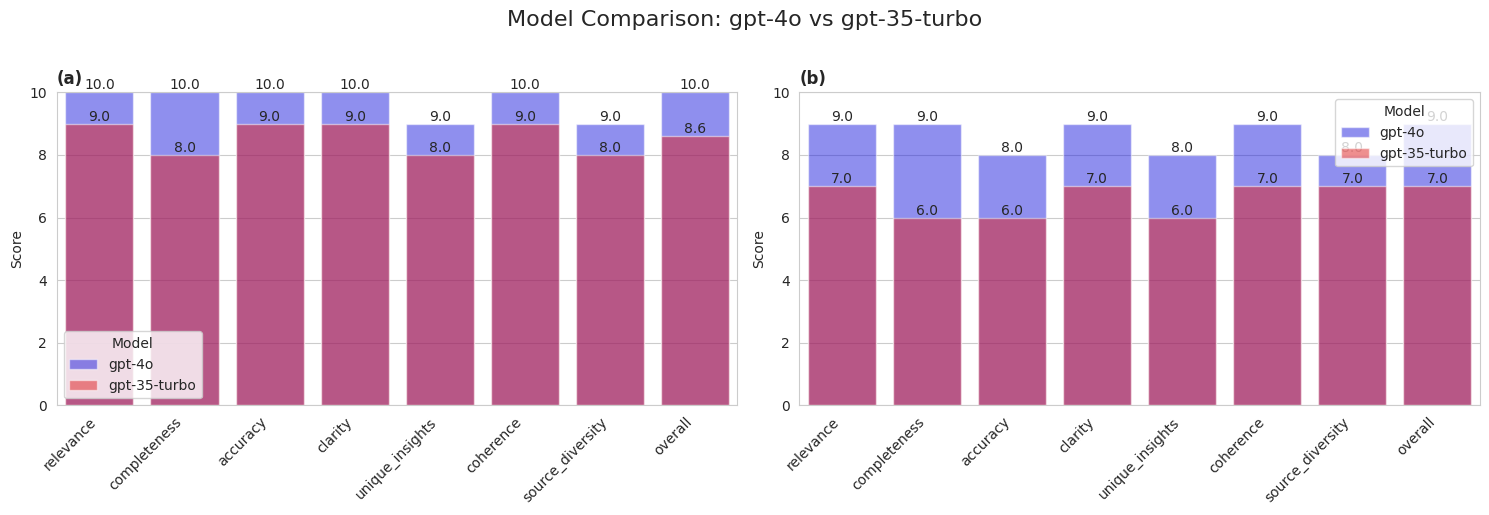

(a) Question: 
Create a comprehensive table comparing representation learning models for polymers. Include the following information for each model:

Model name
Year introduced
Key authors/research group
Type of representation (e.g., graph-based, sequence-based, 3D structure-based)
Input features used
Dimensionality of the learned representation
Training data type and size
Key applications (e.g., property prediction, polymer design)
Notable advantages
Limitations or challenges

After the table, provide a brief analysis (2-3 paragraphs) of the current trends in polymer representation learning, highlighting the most promising approaches and areas for future research. Please cite relevant papers for each model and in your analysis.

(b) Question: 
Create a comparative analysis of machine learning models used for predicting glass transition temperature (Tg) and melting temperature (Tm) of polymers. Include the following in your analysis:

A table comparing at least 5 different models, with

In [47]:
key = keys[1]
visualize_model_scores(scores, key, questions)

/tmp/ipykernel_1306540/3040957943.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1306540/3040957943.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


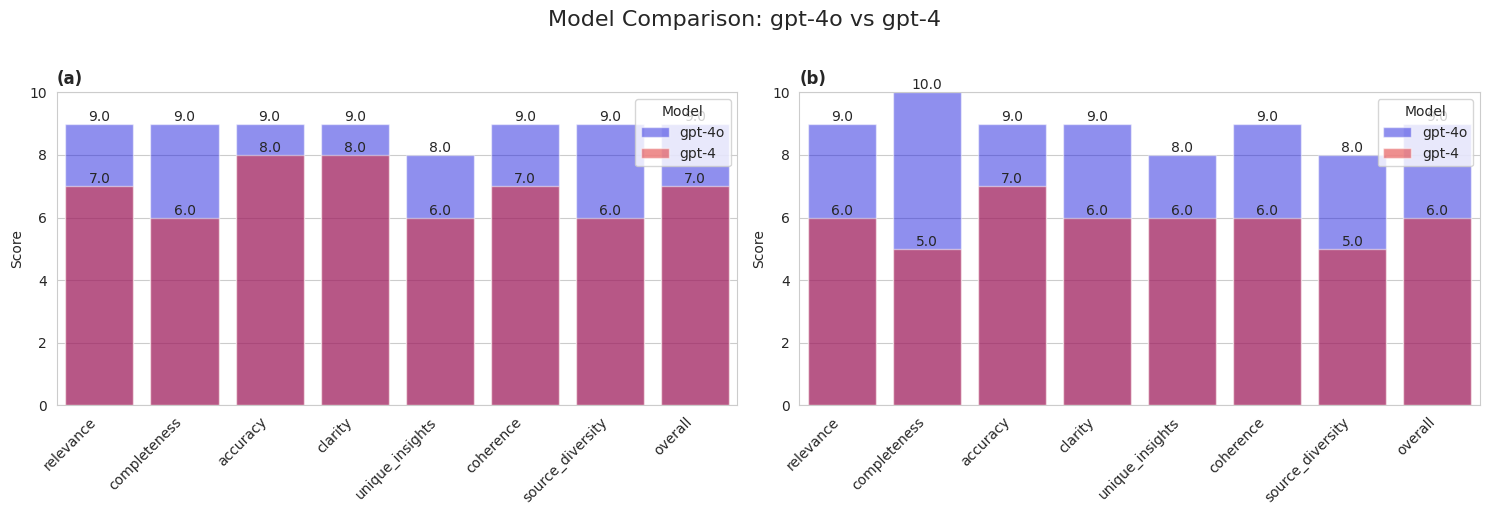

(a) Question: 
Create a comprehensive table comparing representation learning models for polymers. Include the following information for each model:

Model name
Year introduced
Key authors/research group
Type of representation (e.g., graph-based, sequence-based, 3D structure-based)
Input features used
Dimensionality of the learned representation
Training data type and size
Key applications (e.g., property prediction, polymer design)
Notable advantages
Limitations or challenges

After the table, provide a brief analysis (2-3 paragraphs) of the current trends in polymer representation learning, highlighting the most promising approaches and areas for future research. Please cite relevant papers for each model and in your analysis.

(b) Question: 
Create a comparative analysis of machine learning models used for predicting glass transition temperature (Tg) and melting temperature (Tm) of polymers. Include the following in your analysis:

A table comparing at least 5 different models, with

In [48]:
key = keys[3]
visualize_model_scores(scores, key, questions)

/tmp/ipykernel_1306540/3040957943.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1306540/3040957943.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


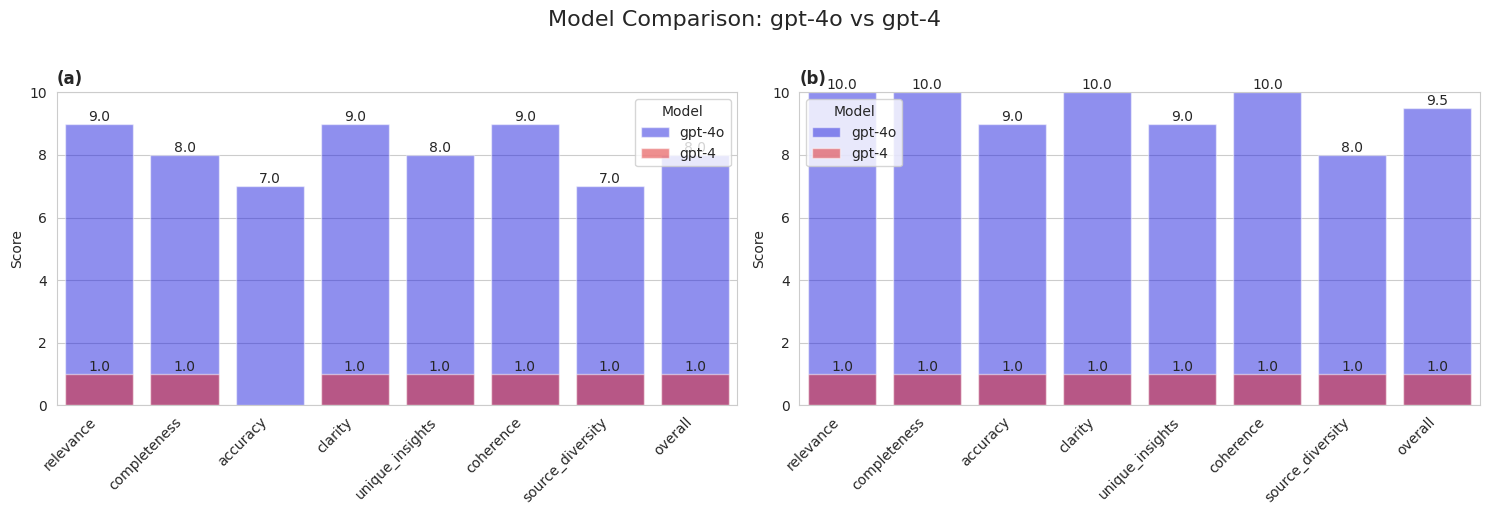

(a) Question: 
Create a comprehensive table comparing representation learning models for polymers. Include the following information for each model:

Model name
Year introduced
Key authors/research group
Type of representation (e.g., graph-based, sequence-based, 3D structure-based)
Input features used
Dimensionality of the learned representation
Training data type and size
Key applications (e.g., property prediction, polymer design)
Notable advantages
Limitations or challenges

After the table, provide a brief analysis (2-3 paragraphs) of the current trends in polymer representation learning, highlighting the most promising approaches and areas for future research. Please cite relevant papers for each model and in your analysis.

(b) Question: 
Create a comparative analysis of machine learning models used for predicting glass transition temperature (Tg) and melting temperature (Tm) of polymers. Include the following in your analysis:

A table comparing at least 5 different models, with

In [49]:
key = keys[2]
visualize_model_scores(scores, key, questions)

In [50]:
len(keys)

6